In [2]:
import deepxde as dde
import numpy as np
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pylab
from numpy import linalg as LA
import math
import scipy.io
from os.path import dirname, join as pjoin
from scipy.stats import truncnorm


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp


In [4]:
S3 = dde.Variable(1.0)

In [5]:

def pde(x, y):
    
    """Self assembly system.
    dy1_t = 1/2*(y3^2)-dy1_x*D1-dy1_xx*D2
    dy2_t = -dD1y2_x +dD2y2_xx
    y3=dy1_x*dD1_y3+dy1_xx*dD2_y3
    All collocation-based residuals are defined here.
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_t = dde.grad.jacobian(y1, x, j=1)
    dy1_x = dde.grad.jacobian(y1, x, j=0)
    dy1_xx = dde.grad.hessian(y1, x, j=0)

    D2=d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3))+f
    F=a*K*T*(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)
    D1=-2*(x[:, 0:1]-b-c*y3)*((d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)))+a*D2)
    dy2_t = dde.grad.jacobian(y2, x, j=1)
    dD1y2_x=dde.grad.jacobian(D1*y2, x, j=0)
    dD2y2_xx = dde.grad.hessian(D2*y2, x,  j=0)
    dD1_y3=dde.grad.jacobian(D1, y3)
    dD2_y3=dde.grad.jacobian(D2, y3)
    tt=100    
    
    return [
        dy1_t-.5*(S3*y3*S3*y3)+D1*dy1_x+D2*dy1_xx,
        dy2_t+dD1y2_x-dD2y2_xx,
        S3*y3-dy1_x*dD1_y3-dy1_xx*dD2_y3,
    ]


In [6]:
def boundary(_, on_initial):
    return on_initial


def pdf1d_T(x):
    mu = 5.
    sigma = .1
    a, b = (0. - mu) / sigma, (6. - mu) / sigma
    rho_T=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)
    return rho_T


def pdf1d_0(x):
    sigma = .2
    mu=0.
    a, b = (0. - mu) / sigma, (6. - mu) / sigma
    rho_0=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)
    return rho_0

In [7]:

x_T = np.transpose(np.linspace(0., 6., 1000))
T_t=200. #Terminal time
x_T=x_T.reshape(len(x_T),1)
time=T_t*np.ones(( 1,len(x_T))).reshape(len(x_T),1)
rho_T=pdf1d_T(x_T).reshape(len(x_T),1)

terminal_time=np.hstack((x_T,time))
rho_T_BC = dde.icbc.PointSetBC(terminal_time, rho_T, component=1)

a, b, c, d, f= 10., 2.1, 0.75, .0045, 0.0005

K, T=1.38066*10**-23, 293.

geom = dde.geometry.Interval(0., 6.)
timedomain = dde.geometry.TimeDomain(0., T_t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
rho_0_BC = dde.icbc.IC(geomtime, lambda x: pdf1d_0(x[:,0:1]) , boundary, component=1)


In [8]:
data = dde.data.TimePDE(geomtime, pde,  [rho_0_BC,rho_T_BC], num_domain=5000, num_initial=500)
net = dde.nn.FNN([2] + [70] *3  + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)


In [9]:
model.compile("adam", lr=1e-3,external_trainable_variables=[S3])
variable = dde.callbacks.VariableValue(
    [S3], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(epochs=10000, callbacks=[variable])


Compiling model...
Building feed-forward neural network...
'build' took 0.072398 s



/opt/anaconda3/lib/python3.8/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.500857 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.46e-02, 4.86e-03, 2.32e-01, 5.49e-01, 5.10e-01]    [2.46e-02, 4.86e-03, 2.32e-01, 5.49e-01, 5.10e-01]    []  
1000      [9.24e-06, 9.92e-04, 5.33e-05, 5.30e-04, 3.40e-01]    [9.24e-06, 9.92e-04, 5.33e-05, 5.30e-04, 3.40e-01]    []  
2000      [1.18e-05, 1.68e-02, 3.63e-04, 6.62e-04, 1.45e-02]    [1.18e-05, 1.68e-02, 3.63e-04, 6.62e-04, 1.45e-02]    []  
3000      [5.10e-06, 6.93e-03, 1.01e-04, 1.24e-04, 7.35e-03]    [5.10e-06, 6.93e-03, 1.01e-04, 1.24e-04, 7.35e-03]    []  
4000      [3.40e-06, 5.19e-03, 8.72e-05, 5.60e-05, 2.07e-03]    [3.40e-06, 5.19e-03, 8.72e-05, 5.60e-05, 2.07e-03]    []  
5000      [3.56e-06, 4.35e-03, 9.77e-05, 8.66e-05, 6.59e-03]    [3.56e-06, 4.35e-03, 9.77e-05, 8.66e-05, 6.59e-03]    []  
6000      [2.72e-06, 3.21e-03, 7.92e-05, 6.75e-05, 6.31e-03]    [2.72e-06, 3.21e-03, 7

Saving loss history to /Users/inodozi/Documents/GitHub/SelfAssembly/Code/loss.dat ...
Saving training data to /Users/inodozi/Documents/GitHub/SelfAssembly/Code/train.dat ...
Saving test data to /Users/inodozi/Documents/GitHub/SelfAssembly/Code/test.dat ...


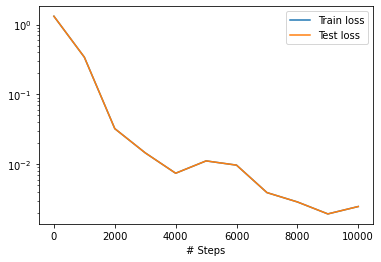

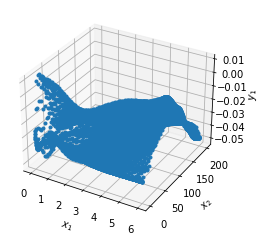

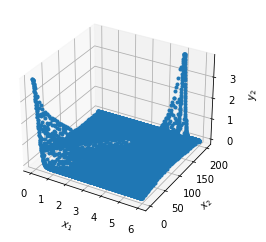

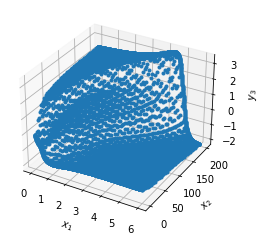

In [10]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)